# Hw3 - Part 2

|Name     |Campus Email| ID  |
|---------|--------------------------------|----------|
|Oren Elmakis| oren.elmakis@campus.technion.ac.il|311265516|
|Alon spinner| alonspinner@campus.technion.ac.il| 305184335|

# Imports

In [37]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os
import glob

import cv2
from PIL import Image

import skimage
from skimage import segmentation
from skimage import color
from skimage.io import imsave
from skimage.future import graph

# from google.colab import drive

import torch
import torchvision
import torchvision.transforms as transforms

In [38]:
# drive.mount('/content/gdrive')
RelPath = ".\\" 

# General Functions

In [39]:
def ImageImport(img_dir):
    images = []  
    
    data_path_jpg=os.path.join(img_dir,'*.jpg')
    data_path_png=os.path.join(img_dir,'*.png')
    GrabbedImageNames=glob.glob(data_path_jpg)+glob.glob(data_path_png)
    
    for ImgName in GrabbedImageNames:
        ImgFile = Image.open(ImgName)
        images.append(ImgFile)
    return images

def SaveImages(images,names,dirname):
  if not os.path.exists(dirname):
    os.makedirs(dirname)    
    print("Directory " , dirname ,  " Created ")
  for image,name in zip(images,names):
    if type(image) is not np.ndarray:
      image=np.array(image)
    imsave(os.path.join(dirname,name+'.jpg'),image)

def PlotImages(images):
    fig,axes = plt.subplots(1,len(images),figsize = (16,2.5))
    for idx,image in enumerate(images):
        axes[idx].imshow(image)
        axes[idx].set_title("Picture Shape: {}".format(np.shape(image)))

def ThumbnailImages(images,max_size):
  ThumbnailImages=[]
  for image in images:
    image_copy=image.copy()
    image_copy.thumbnail((max_size,max_size))
    ThumbnailImages.append(image_copy)
  return ThumbnailImages

def CropImages(images,LTRB=(200,100,1200,600)):
  Croppedimages=[]
  for image in images:
    Croppedimages.append(image.crop(LTRB))
  return Croppedimages

In [40]:
"""
Author: Tal Daniel
"""

def image_seq_to_video(imgs_path, output_path='./video.mp4', fps=15.0):
    output = output_path
    img_array = []
    for filename in glob.glob(os.path.join(imgs_path, '*.jpg')):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        # img = cv2.resize(img, (width // 2, height // 2))
        img = cv2.resize(img, (width, height))
        height, width, layers = img.shape
        size = (width, height)
        img_array.append(img)

    print(size)
    print("writing video...")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Be sure to use lower case
    out = cv2.VideoWriter(output, fourcc, fps, size)
    # out = cv2.VideoWriter('project.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    print("saved video @ ", output)


def video_to_image_seq(vid_path, output_path='./datasets/OTB/img/Custom/'):
    os.makedirs(output_path, exist_ok=True)
    vidcap = cv2.VideoCapture(vid_path)
    success, image = vidcap.read()
    count = 0
    print("converting video to frames...")
    while success:
        fname = str(count).zfill(4)
        cv2.imwrite(os.path.join(output_path, fname + ".jpg"), image)  # save frame as JPEG file
        success, image = vidcap.read()
        # print('Read a new frame: ', success)
        count += 1
    print("total frames: ", count)

# Q1
Film a short video of yourself (you can use your phone/webcam for that), but without too much camera movement. You on the other hand, can move -- walk/move you hands... (we expect you to). Convert the video to frames and resize the images for a reasonable not too high resolution (lower than 720p ~ 1280x720 pixles). You can use the function in frame_video_convert.py to help you. Display 2 frames in the report.

In [41]:
Alon_oren_vid_path = os.path.join(RelPath,"my_data\\video\\video_alon&oren.mp4")
Alon_oren_imgseq_pat = os.path.join(RelPath , "my_data\\video\\images\\New folder(4)")
# video_to_image_seq(Alon_oren_vid_path,Alon_oren_imgseq_pat)
Alon_oren_Hands_images=ImageImport(Alon_oren_imgseq_pat)
Alon_oren_Hands_Thumbnail_images=ThumbnailImages(Alon_oren_Hands_images,800)

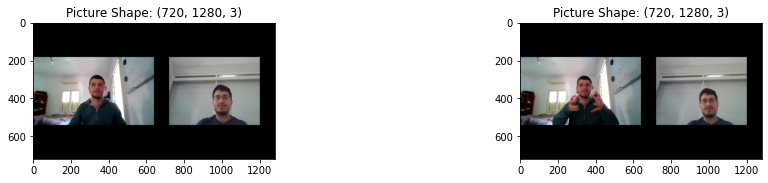

In [42]:
PlotImages([Alon_oren_Hands_images[0],Alon_oren_Hands_images[100]])

# Q2
Segment yourself out of the video (frame-by-frame) using one of the methods (classic or deep). Display 2 frames in the report.

## Init and functions

In [43]:
# download and load the pre-trained model
model = torch.hub.load('pytorch/vision:v0.5.0', 'deeplabv3_resnet101', pretrained=True)
# put in inference mode
model.eval();

# define device and adjust model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#model labels
deeplabv3_labels = ['background','aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']
print(["{}: {}".format(i , deeplabv3_labels[i]) for i in range(len(deeplabv3_labels))])

Using cache found in C:\Users\orene/.cache\torch\hub\pytorch_vision_v0.5.0


['0: background', '1: aeroplane', '2: bicycle', '3: bird', '4: boat', '5: bottle', '6: bus', '7: car', '8: cat', '9: chair', '10: cow', '11: diningtable', '12: dog', '13: horse', '14: motorbike', '15: person', '16: pottedplant', '17: sheep', '18: sofa', '19: train', '20: tvmonitor']


In [44]:
def PassForward2deeplabv3(images):
    preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

    segmented_images=[]
    for image in images:
      #into model
      t_image = preprocess(image).unsqueeze(0).to(device) #unsqueeze makes the size [1,3,W,H]
      with torch.no_grad(): #quicken outputs, dont want to calculate gradients in forward
        output = model(t_image)['out'][0]
      output_predictions = output.argmax(0) #initial output is of size (21,H,W) containing probabilties for each class for each pixel. collapse to (1,H,W)
      output_predictions=output_predictions.byte().cpu()

      mask = torch.zeros_like(output_predictions).float().to(device) #matrix filled with zeros
      mask[output_predictions == 15 ] = 1 #bring forth everything that isnt background
      mask=mask.unsqueeze(2).byte().cpu().numpy() #3 channels so product with RGB will work

      #apply mask on image
      masked_image=Image.fromarray(np.array(image) * mask)
      segmented_images.append(masked_image)

    return segmented_images

def transparentFromBlack(images):
  transparent_images=[]
  for image in images:
    img = image.convert("RGBA")
    datas = img.getdata()
    newData = []
    for item in datas:
        if item[0] == 0 and item[1] == 0 and item[2] == 0:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)
    transparent_images.append(img)
  return transparent_images

## Results

In [45]:
seg_AlonHands_images=PassForward2deeplabv3(Alon_oren_Hands_Thumbnail_images)
# dirname= os.path.join(RelPath , "my_data\\video\\images\\New folder(4)\\transparent")

In [226]:
# for count,image in enumerate(seg_AlonHands_images,1):
#     image=np.array(image)
#     imsave(os.path.join(dirname,str(count).zfill(4)+'.jpg'),image)

In [46]:
tr_seg_AlonHands_images=transparentFromBlack(seg_AlonHands_images)

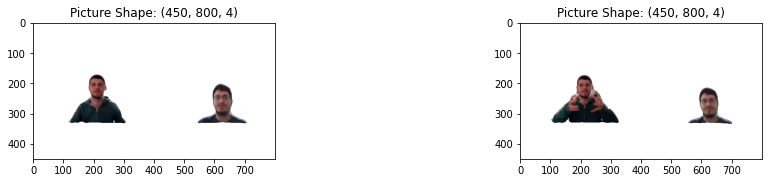

In [47]:
PlotImages([tr_seg_AlonHands_images[0],tr_seg_AlonHands_images[100]])

# Q3
Pick one of the objects in the supplied videos (./data/dancing_man_model.mp4, ./data/dinosaur_model.mp4, ./data/jet_model.mp4), convert it to images and segement it out using one of the methods (classic or deep). Display 2 frames in the report. You can choose another object from: https://pixabay.com/videos/search/green%20screen/ (https://pixabay.com/videos/search/green%20screen/). 

## Functions

In [48]:
def GreenScreen2White(image):
  npimage=np.array(image)
  HSV_image=cv2.cvtColor(npimage, cv2.COLOR_RGB2HSV)
  HSV_Mask=(HSV_image[:,:,0]>40) & (HSV_image[:,:,0]<90) & (HSV_image[:,:,2]>150)
  npimage[HSV_Mask==1]=(255,255,255) 
  return Image.fromarray(npimage)

def RemoveGreenScreen(images):
  NoGreenImages=[]
  for image in images:
    g2w_image=GreenScreen2White(image)
    image = g2w_image.convert("RGBA")
    datas = image.getdata()

    newData = []
    for item in datas:
      if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
      else:
            newData.append(item)
    image.putdata(newData)
    NoGreenImages.append(image)

  return NoGreenImages

## Results

In [49]:
greenscreen_vid_path=os.path.join(RelPath,"my_data\\video\\videocom.mp4")
greenscreen_imgseq_path= os.path.join(RelPath , "my_data\\video\\images\\New folder")
video_to_image_seq(greenscreen_vid_path,greenscreen_imgseq_path)
gs_robot_images=ImageImport(greenscreen_imgseq_path)

converting video to frames...
total frames:  215


In [50]:
crp_gs_robot_images=CropImages(gs_robot_images,LTRB=(200,100,1200,600))
transparent_robot_images=RemoveGreenScreen(crp_gs_robot_images)

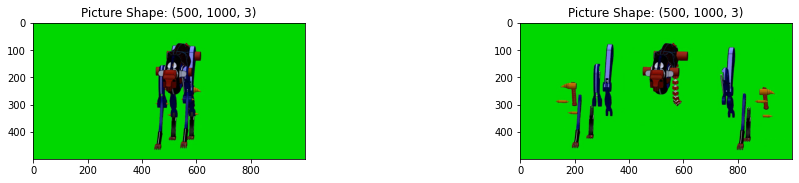

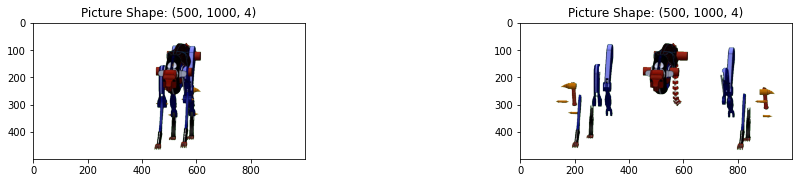

In [51]:
# transparent_robot_images.append(transparent_robot_images[0:10]) 
transparent_robot_images2 = transparent_robot_images[0:10]
for count,i in enumerate(transparent_robot_images,0):
    if count<30 or count>30 and count%2:
        transparent_robot_images2.append(i)
    if count>65 and count<90:
        transparent_robot_images2.append(i)
PlotImages([crp_gs_robot_images[0],crp_gs_robot_images[100]])
PlotImages([transparent_robot_images[0],transparent_robot_images[100]])

In [52]:
print(len(transparent_robot_images2))
print(len(tr_seg_AlonHands_images))

156
255


# Q4

Put it all together - pick a background (can be a video or static image), put yourself (the segmented-self) and the segemented object on the background. Stitch it frame-by-frame (don't make the video too long or it will take a lot of time, 10secs maximum). Display 2 frames of the result. Convert the frames back to video. You can use the function in frame_video_convert.py to help you.

In [53]:
def pasteIm2ONim1(im1,im2,initial_pos):
  copy = im1.copy()
  copy.paste(im2,initial_pos,im2)
  return copy

def MeshImages(base_im,over_im,initial_pos,maxsize_over_im):
  copy_over_im=over_im.copy()
  copy_over_im.thumbnail((maxsize_over_im,maxsize_over_im))
  MeshImage=pasteIm2ONim1(base_im,copy_over_im,initial_pos)
  return MeshImage

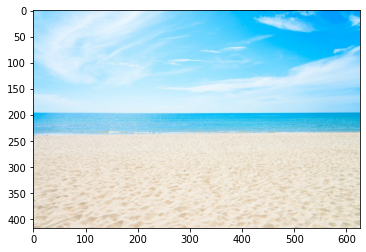

In [54]:
BeachImage=Image.open(RelPath+'/data/beach.jpg')
plt.imshow(BeachImage)

In [55]:
Movie_images=[]
for im_Alon,im_Robot in zip(tr_seg_AlonHands_images[90:],transparent_robot_images2):
  img=MeshImages(BeachImage,im_Alon,(-100,-120),1500)
  img=MeshImages(img,im_Robot,(140,250),300)
  Movie_images.append(img)

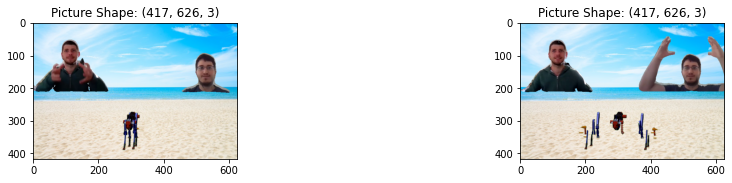

In [56]:
PlotImages([Movie_images[0],Movie_images[100]])

In [57]:
names=[]
for count in range(len(Movie_images)):
  names.append(str(count).zfill(4))
dirname=RelPath+'\\my_data\\video\\FinalMovie_ImageSeq'
SaveImages(Movie_images,names,dirname)

In [58]:
image_seq_to_video(dirname, dirname + '\FinalMovie.mp4', fps=15.0)

(626, 417)
writing video...
saved video @  .\code\\my_data\video\FinalMovie_ImageSeq\FinalMovie.mp4
